<a href="https://colab.research.google.com/github/tanguy-linard/2024_MLEES/blob/main/Copie_de_S2_4_Wildfire_Risk_Italy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In week 3's final notebook, we will train classifiers on real [wildfire](https://en.wikipedia.org/wiki/Wildfire) data to map the fire risk in different regions of Italy. To keep the data size manageable, we will focus on the coastal [Liguria region](https://en.wikipedia.org/wiki/Liguria) that experiences a lot of wildfires, especially during the winter.



---



**Credits**

This online tutorial would not be possible without invaluable contributions from [Andrea Trucchia](https://www.researchgate.net/profile/Andrea-Trucchia) (reduced data, methods), [Giorgio Meschi](https://www.linkedin.com/in/giorgio-meschi-86216b180/) (code, methods), and [Marj Tonini](https://www.researchgate.net/profile/Marj-Tonini-2) (presentation, methods). The methodology builds upon the following article:

[Trucchia, A.; Meschi, G.; Fiorucci, P.; Gollini, A.; Negro, D., Defining Wildfire Susceptibility Maps in Italy for Understanding Seasonal Wildfire Regimes at the National Level, *Fire*, (2022)](https://www.mdpi.com/2571-6255/5/1/30)

which generalizes the study below from the Liguria region (our case study) to all of Italy:

[Tonini, Marj, et al. "A machine learning-based approach for wildfire susceptibility mapping. The case study of the Liguria region in Italy." *Geosciences* 10.3 (2020): 105.](https://www.mdpi.com/2076-3263/10/3/105)



---



# Exercise 4: Mapping Wildfire Susceptibility in the Liguria Region with Simple Machine Learning Classifiers

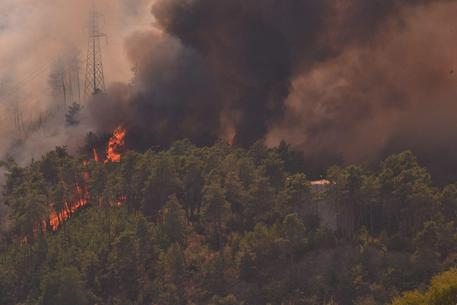

**Caption**: A wildfire in Italy. Can we predict which locations are most susceptible to wildfires using simple classifiers? 🔥

**Source**: [ANSA](https://www.ansa.it/english/news/2015/08/14/wildfires-in-italy-up-120-this-summer-on-past-two-years_f6e4eff7-ac07-4f9e-aa5a-e61f8c2ad7f2.html)

Let's start by downloading and loading the datasets into memory using the [`pooch`](https://pypi.org/project/pooch/), [`pickle5`](https://pypi.org/project/pickle5/), and [`GeoPandas`](https://geopandas.org/en/stable/) libraries:

In [1]:
# Install geopandas and pickle5
%pip install geopandas
%pip install pickle5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=255318 sha256=b7b3efe447f5ba8f96715303501c892428d83bf7fbe56f9b806866b0ed1582ee
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772be5c71c16add0426acf9e1f64353235c
Successfully built pickle5


In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle5 as pickle
import pooch

In [3]:
# Function to load the data
def load_data(path):

    # Load the content of the pickle file (using pickle5 for Google Colab)
    with open(path, "rb") as fh:
        points_df = pd.compat.pickle_compat.load(fh)

    # Convert it to a Geopandas `GeoDataFrame` for spatial analysis
    points_df = gpd.GeoDataFrame(points_df,
                                 geometry=gpd.points_from_xy(np.float64(points_df.x),
                                                             np.float64(points_df.y)))
    return points_df

In [4]:
# Path to the data in UNIL OneDrive
variables_path = pooch.retrieve('https://unils-my.sharepoint.com/:u:/g/personal/tom_beucler_unil_ch/EU4FQkuYknFDiDfd7droyAcBP0qFOR5-c-_Oq74gjhTGwQ?download=1',
                            known_hash='e8ebc70f972b5af4ef3d6110dcd61ce01ce5a830dcdb7d2c9e737aeab781606c')
wildfires_path = pooch.retrieve('https://unils-my.sharepoint.com/:u:/g/personal/tom_beucler_unil_ch/EcjqeERsnIRHjhcx1ZFVNggBS7nPUkW530XRrpVUB-qnOw?download=1',
                             known_hash='361f067aafbac8add8f8a9a5c630df3c962cd37a2f125f420e7b9330fd0a1a4c')

In [5]:
# Load the data and convert it to a GeoPandas `GeoDataFrame`
# This can take a minute
variables = load_data(variables_path)
wildfires = load_data(wildfires_path)

/usr/lib/python3.10/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)


## Part I: Pre-Processing the Dataset for Classification

**Q1) After analyzing the topography and land cover data provided in `variables`, create your input dataset `inputs` from `variables` to predict the occurence of wildfires (`wildfires`). Keep at least one categorical variable (`veg`, `bioclim`, or `phytoclim`).**

Hint 1: Refer to the documentation [at this link](https://unils-my.sharepoint.com/:t:/g/personal/tom_beucler_unil_ch/EREf92h-43VBtgPjwveMfrQBRahitmHxBKAtNx04lleh7Q?e=Fx6nad) to know what the different `keys` of `variables` refer to.

Hint 2: You may refer to Table 1 of [Tonini et al.](https://www.mdpi.com/2076-3263/10/3/105), copied below, to choose your input variables, although we recommend starting with less inputs at first to build a simpler model and avoid overfitting.

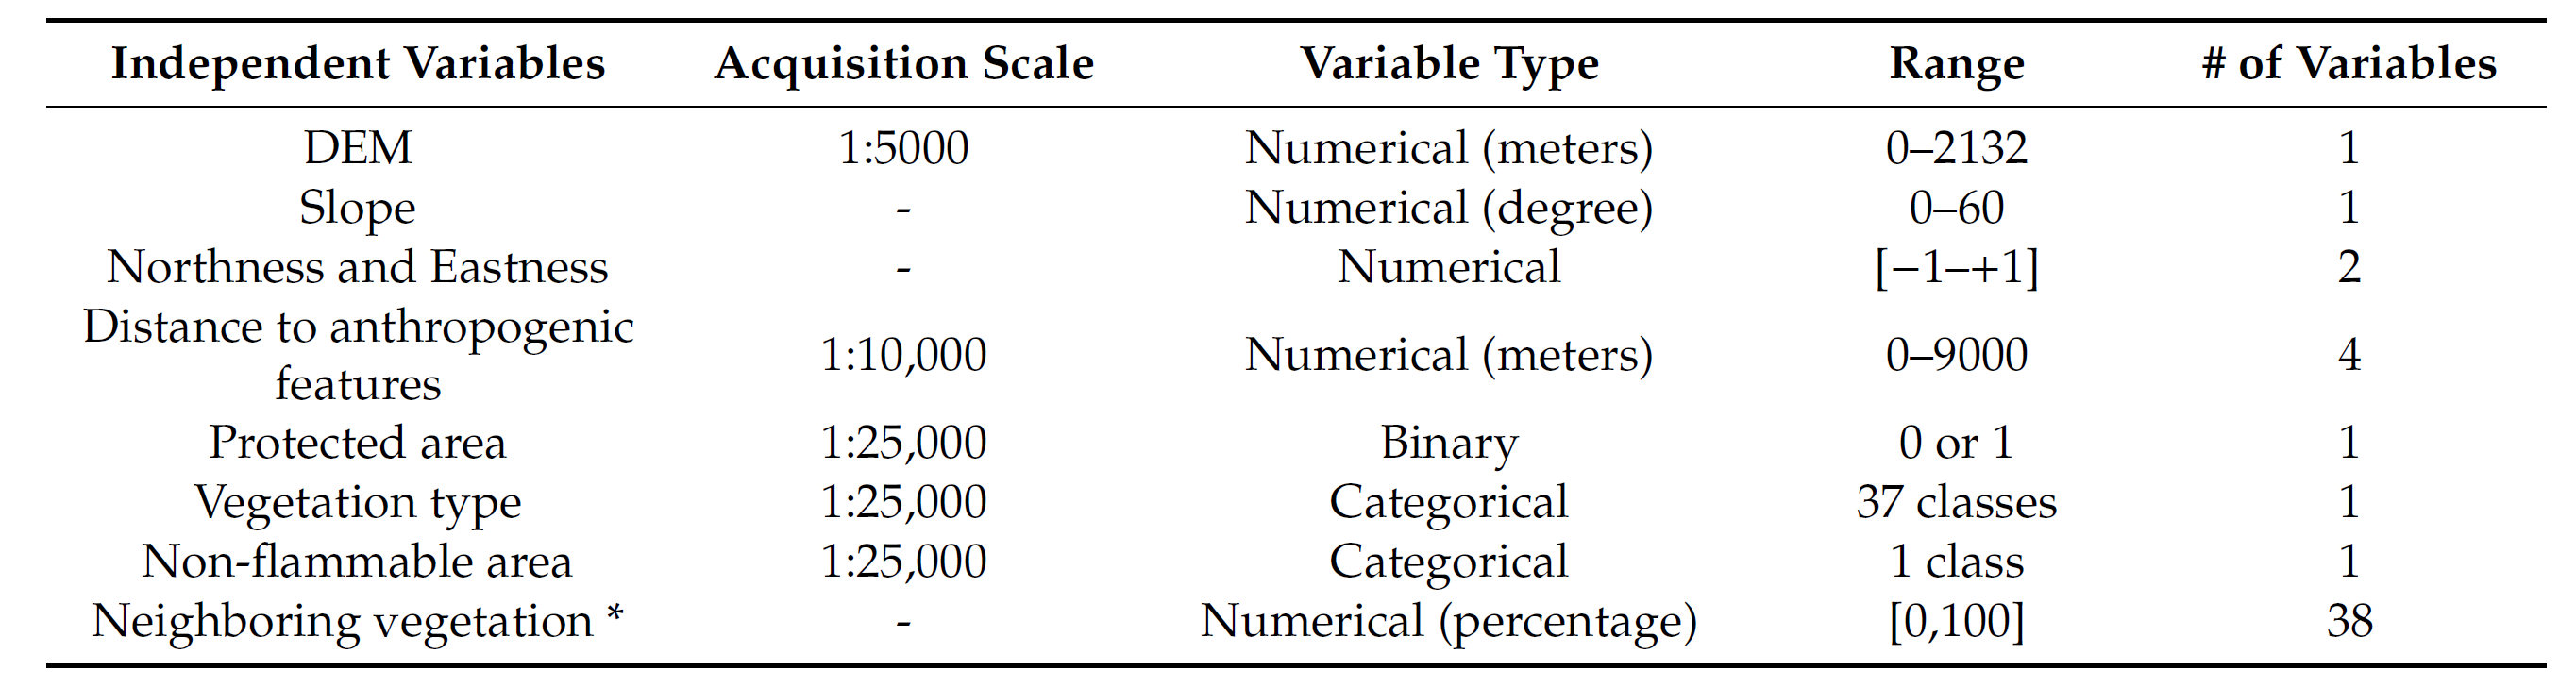

Here are some pandas commands you could use to explore your data.
[.head()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html)
[.columns()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.columns.html)
[.describe()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)

In [7]:
# Explore the `variables` dataset
#########################################################################################################
# 1. What kind of data is provided in the "variables" panda DataFrame?
#########################################################################################################
# Can you print the variable names?
print(variables.columns)

Index(['row', 'col', 'x', 'y', 'dem', 'slope', 'north', 'east', 'veg',
       'urban_d', 'roads_d', 'crops_d', 'tracks_d', 'bioclim', 'phytoclim',
       'temp_1', 'temp_2', 'prec_1', 'prec_2', 'perc_0', 'perc_21', 'perc_22',
       'perc_23', 'perc_32', 'perc_33', 'perc_34', 'perc_37', 'point_index',
       'geometry'],
      dtype='object')


In [8]:
# Can you print a table with all the statistics of each variable in the dataframe?
print(variables.describe)

<bound method NDFrame.describe of              row   col             x             y  dem      slope     north  \
point_index                                                                    
0              1  1158  1.494904e+06  4.946934e+06  563  20.843185 -0.994807   
1              2  1156  1.494704e+06  4.946834e+06  527  23.599121 -0.978550   
2              2  1157  1.494804e+06  4.946834e+06  525  26.699856 -0.996631   
3              2  1158  1.494904e+06  4.946834e+06  519  24.512413 -0.997833   
4              2  1159  1.495004e+06  4.946834e+06  532  20.421495 -0.966900   
...          ...   ...           ...           ...  ...        ...       ...   
519336       980    40  1.383104e+06  4.849034e+06  125  29.669502 -0.822824   
519386       981    42  1.383304e+06  4.848934e+06  139  23.541714 -0.972621   
519388       981    44  1.383504e+06  4.848934e+06  113  16.290375 -0.372128   
519422       982    44  1.383504e+06  4.848834e+06   95  23.240271 -0.925640   
519423

There are 25 columns (variables) in the DataFrame. It is probably best to start simple and just use a few variables to make the wildfire prediction.

Can we use a very simple model to predict wildfires ❓

A simple model might contain `dem`, `slope`, `veg` and `bioclim`. We can use it as a baseline to evaluate model performance when you use other combinations to train the model.

However, we cannot tell you which combination would perform the best as we have not done an extensive search while preparing the notebook.

In [15]:
# Here you will filter the DataFrame so that only the variables you want are in the input
############################################################################################################
# 1. Drop down the names of variables you want here so that pandas can do the filtering for you.
############################################################################################################
vars_tokeep = ['dem', 'slope', 'veg', 'bioclim']

In [16]:
############################################################################################################
# 2. Create a new dataframe 'inputs' with just the variables you want
############################################################################################################
inputs = variables[vars_tokeep] # Filter 'variables' dataframe
inputs.head # print the first few columns to make sure everything works fine

<bound method NDFrame.head of              dem      slope veg bioclim
point_index                            
0            563  20.843185  34      15
1            527  23.599121  34      15
2            525  26.699856  34      15
3            519  24.512413  34      15
4            532  20.421495  34      15
...          ...        ...  ..     ...
519336       125  29.669502  37       0
519386       139  23.541714  32       0
519388       113  16.290375  32       0
519422        95  23.240271  37       0
519423        67  15.023369  32       0

[528669 rows x 4 columns]>

**Q2) To avoid making inaccurate assumptions about which types of vegetation and non-flammable area are most similar, convert your categorical inputs into one-hot vectors.**

Hint 1: You may use the [`fit_transform`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder.fit_transform) method of `scikit-learn`'s [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) class to convert categorical inputs into one-hot vectors.

Hint 2: Don't forget to remove the categorical variables from your input dataset, e.g. using [`drop`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html) if you are still using a `GeoDataFrame`, or [`del`](https://docs.python.org/3/reference/simple_stmts.html#the-del-statement)/[`pop`](https://docs.python.org/3/library/stdtypes.html#dict.pop) if you are working with a Python dictionary.

Hint 3: There are numerous ways to change the categorical data into one-hot vectors. It is quite easy to do in `pandas`, but scikit-learn also provides some transformers that could be useful, including [.ColumnTransformer()](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) and [Pipeline()](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

In the guided reading, you have seen how these functions are used. Try experiment with them and see if you prefer using these scikit transformers or pandas.

In [19]:
############################################################################################################
# 1. Import OneHotEncoder for 'veg' and 'bioclim' data, and pandas
############################################################################################################
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
############################################################################################################
# 2. Initiate OneHotEncoder object, set the 'sparse' option to False
############################################################################################################
enc = OneHotEncoder(sparse_output=False)

In [20]:
############################################################################################################
# 3. Convert categorical variables into one-hot vectors
############################################################################################################
# Convert categorical variables with 'enc'
veg_onehot = enc.fit_transform(variables[['veg']])
bioclim_onehot = enc.fit_transform(variables[['bioclim']])

# Convert 'veg_onehot' and 'bioclim_onehot' to pandas DataFrames
veg_transform = pd.DataFrame(veg_onehot) # veg
bio_transform = pd.DataFrame(bioclim_onehot) # bioclim

# 4. Print the shape of 'veg_transform'
print(veg_transform.shape)

# Don't change these!
veg_transform = veg_transform.add_prefix('v_')
bio_transform = bio_transform.add_prefix('b_')

(528669, 7)


In [21]:
############################################################################################################
# 5. Convert 'inputs' into Panda DataFrame
############################################################################################################
inputs_gdf = pd.DataFrame(inputs)
############################################################################################################
# 6. Add 'veg_transform' and 'bio_transform' into the inputs DataFrame
############################################################################################################
inputs_gdf = inputs_gdf.join(veg_transform)
inputs_gdf = inputs_gdf.join(bio_transform)

In [22]:
############################################################################################################
# 7. Use .drop() to delete 'veg' and 'bioclim' from DataFrame
inputs_gdf.drop(columns=['veg', 'bioclim'], inplace=True)

Now that we built our `inputs` dataset, we are ready to build our `outputs` dataset!

**Q3) Using the `point_index` column of `wildfires` and `variables`, create your `outputs` dataset, containing 1 when there was a wildfire and 0 otherwise.**

Hint: Check that `inputs` and `outputs` have the same number of cases by looking at their `.shape[0]` attribute.

In [23]:
#####################################################################################################################
# 1. Use numpy to initialize an outputs array with the same shape as the 'point_index' column in the variables table
#####################################################################################################################
outputs = np.zeros_like(variables['point_index'])
#####################################################################################################################
# 2. Pull out the indices of wildfire locations from the pandas DataFrame 'wildfires'
#####################################################################################################################
wildfiresindex = wildfires.index

In [24]:
#####################################################################################################################
# 3. Fill the zero array with ones if a fire broke out at a specific location index.
# Here you can use a for loop for this task
#####################################################################################################################
#####################################################################################################################
for index in wildfiresindex:
    outputs[index] = 1

In [25]:
#####################################################################################################################
# 4. Check that `inputs` and `outputs` have the same shape[0]
#####################################################################################################################
print(inputs.shape[0] == outputs.shape[0])

True


**Q4) Separate your `inputs` and `outputs` datasets into a training and a test set. Keep at least 20% of the dataset for testing.**

Hint 1: You may use `scikit-learn`'s [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

Hint 2: If you are considering optimizing the hyperparameters of your classifier, form a validation dataset as well.

Hint 3: We recommend performing the split on the indices so that it is easier to track what points are in which dataset after splitting. You will have an easier time when plotting the susceptibility map.

In [26]:
#####################################################################################################################
# 1. Import train_test_split()
#####################################################################################################################
from sklearn.model_selection import train_test_split

In [45]:
#####################################################################################################################
# 2. Create a list with all indices in the input [0,1,2,...]
#####################################################################################################################
all_indices = list(range(len(inputs_gdf)))

#####################################################################################################################
# 3. Convert the inputs_gdf dataframe to numpy array
#####################################################################################################################
#inputs_gdf = inputs_gdf.to_numpy()

#####################################################################################################################
# 4. Apply train_test_split on 'all_indices', and store training indices in 'indx_train', test indices in 'indx_test'
#####################################################################################################################
indx_train, indx_test = train_test_split(all_indices, test_size=0.2, random_state=42)

#####################################################################################################################
# 5. Create training and test sets with indx_train and indx_test
#####################################################################################################################
X_train, X_test, y_train, y_test = inputs_gdf[indx_train], inputs_gdf[indx_test], outputs[indx_train], outputs[indx_test]

In [31]:
# Check the shape of your training(/validation)/test sets
# and make sure you kept at least 20% of your dataset for testing

Congratulations, you have created a viable wildfire dataset to train a machine learning classifier! 😃 Now let's get started 🔥

<a name="previous_ex"></a>
## Part II: Training and Benchmarking the Machine Learning Classifiers

**Q5) Now comes the machine learning fun! 🤖 Train multiple classifiers on your newly-formed training set, and make sure that at least one has the `predict_proba` method once trained.**

Hint: You may train a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) or an [`ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html), but we encourage you to be creative and include additional classifiers you find promising! 💻

In [46]:
#####################################################################################################################
# 1. Import RandomForestClassifier
#####################################################################################################################
from sklearn.ensemble import RandomForestClassifier
#####################################################################################################################
# 2. Convert X_train and X_test into pandas DataFrame
#####################################################################################################################
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [33]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,143.0,3.441056,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,204.0,21.165070,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,304.0,28.740286,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,318.0,18.950947,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,522.0,19.906359,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422930,431.0,14.090720,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
422931,560.0,3.790979,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
422932,213.0,19.034899,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
422933,413.0,0.955438,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [40]:
#####################################################################################################################
# 3. Initiate RF classifier and fit it on training set
#####################################################################################################################
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# (Optional) Conduct a hyperparameter search on the validation set
# e.g., using scikit-learn's RandomizedSearchCV

**Q6) Compare the performance and confusion matrices of your classifiers on the test set. Which classifier performs best in your case?**

Hint 1: You may use the [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) to quantify your classifier's performance, but don't forget there are [many other performance metrics to benchmark binary classifiers](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

Hint 2: You can directly calculate the confusion matrix using `scikit-learn`'s [`confusion_matrix` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [42]:
#####################################################################################################################
# 1. Import accuracy_score, confusion_matrix, and ConfusionMatrixDisplay
#####################################################################################################################
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [47]:
#####################################################################################################################
# 2. Use rfc to make prediction on test set
#####################################################################################################################
rfc_preds = rfc.predict(X_test)

In [48]:
#####################################################################################################################
# 3. Use accuracy_score to infer trained classifier performance
#####################################################################################################################
rfc_acc = accuracy_score(y_test, rfc_preds)

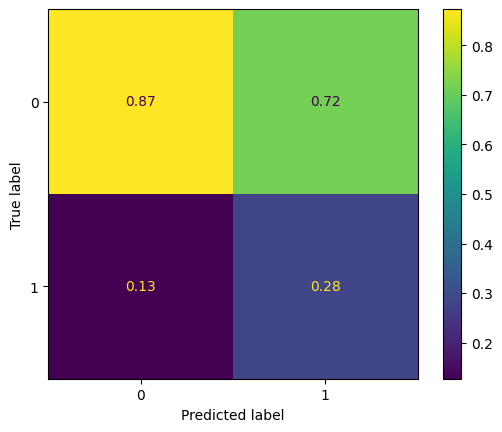

In [49]:
#####################################################################################################################
# 4. Plot the confusion matrix
#####################################################################################################################
cm = confusion_matrix(y_test, rfc_preds, normalize='pred') # Get a confusion matrix 'cm', use 'pred' for the normalize option
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Use ConfusionMatrixDisplay to visualize 'cm'
disp.plot()

For comparison, below is the confusion matrix obtained by the paper's authors:


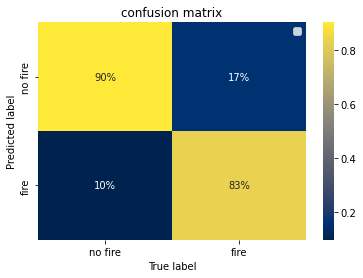

## Part III: Making the Susceptibility Map

**Q7) Using all the classifiers you trained that have a `predict_proba` method, predict the probability of a wildfire over the entire dataset.**

Hint: `predict_proba` will give you the probability of both the presence and absence of a wildfire, so you will have to select the right probability.

In [50]:
#####################################################################################################################
# 1. Predict the probability of a wildfire or not on the *entire* dataset
#####################################################################################################################
predprob_rf = rfc.predict_proba(inputs_gdf) # Use .predict_proba in the 'rfc' classifier to process the entire dataset

In [51]:
#####################################################################################################################
# 2. Extract the probability of a wildfire happening over the entire period of the dataset for each instance
#####################################################################################################################
rf_testprob_fire = predprob_rf[:, 1] # Hint: predprob_rf shape = [:,2], select the second column

**Q8) Make the susceptibility map 🔥**

Hint 1: The `x` and `y` coordinates for the map can be extracted from the `variables` dataset.

Hint 2: You can simply [`scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) `x` versus `y`, and color the dots according to their probabilities (`c`=probability of a wildfire) to get the susceptibility map.

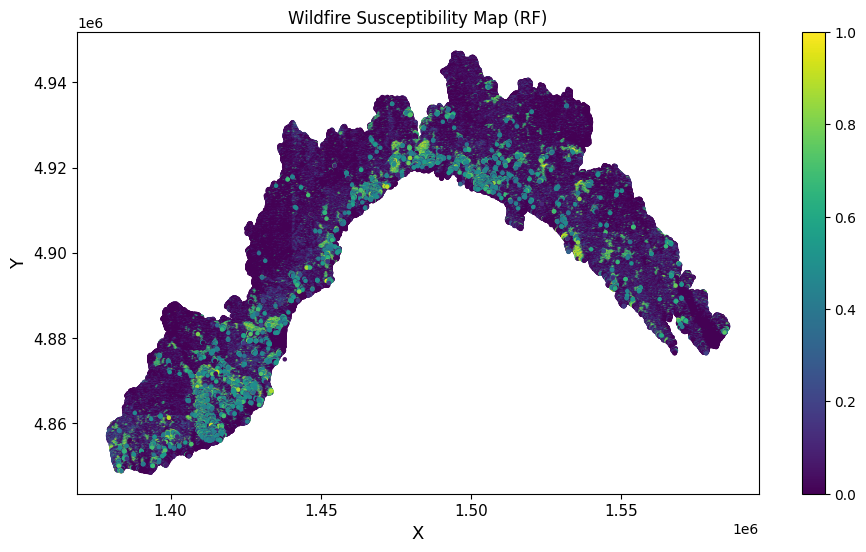

In [52]:
# Scatter ['x'] vs ['y'] columns in the entire dataframe and color the dots with the predicted probability 'rf_testprob_fire'
# to make the susceptibility map

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6 + 5, 4 + 2))
cmploy = ax.scatter(variables['x'], variables['y'], s=5, c=rf_testprob_fire, cmap='viridis')
plt.colorbar(cmploy, ax=ax)
ax.set_title('Wildfire Susceptibility Map (RF)')
ax.set_ylabel('Y', size=13)
ax.set_xlabel('X', size=13)
ax.tick_params(axis='both', which='major', labelsize=11)
plt.show()

You should get a susceptibility map that looks like the one below. Does your susceptibility map depend on the classifier & the inputs you chose? Which map would you trust most?

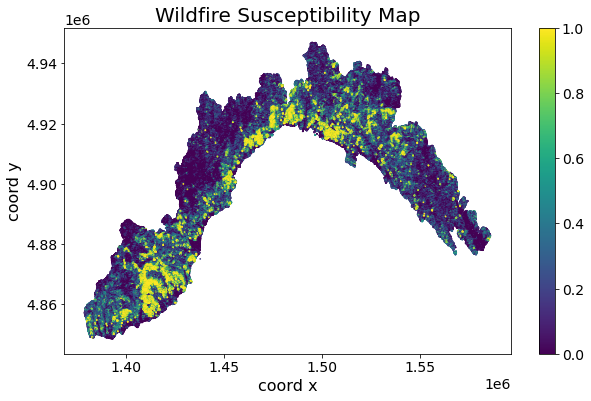

It seems like our model was too simple to generate a useful map 😞 .
Your TA actually experimented training a RandomForest model with 10 variables and got a 91% accuracy!

So you should definitely try combinations of different variables to get a map that is better than what you just got.



# Bonus Exercise 4: Exploring the Susceptibility Map's Sensitivity to Seasonality and Input Selection

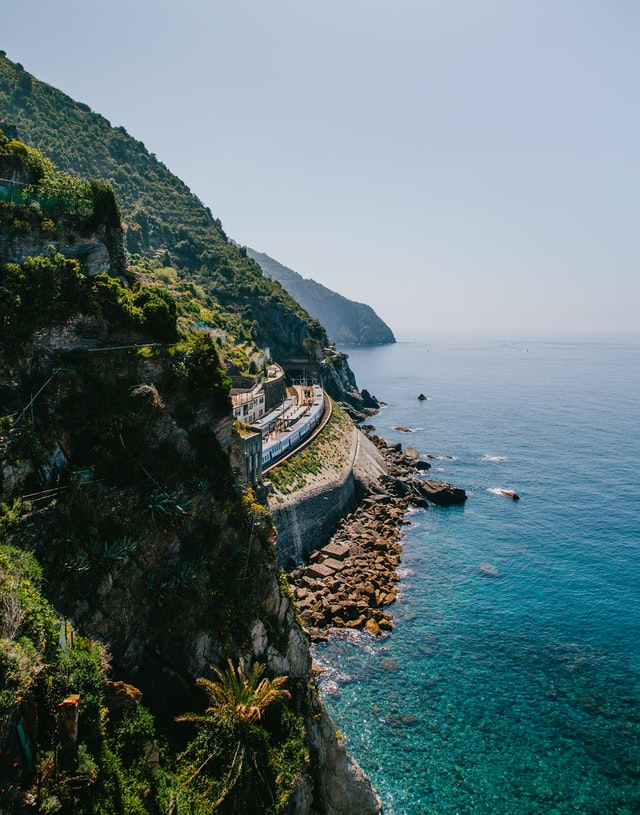

**Caption:** The Liguria region (Cinque Terre), after you save it from raging wildfires using machine learning ✌

## Part I: Seasonality

**Q1) Using the `season` column of `wildfires`, separate your data into two seasonal datasets (1=Winter, 2=Summer).**

Hint: When splitting your `inputs` into two seasonal datasets, keep in mind that `temp_1` and `prec_1` are the climatological mean temperatures and precipitation during winter, while `temp_2` and `prec_2` are the climatological mean temperature and precipitation during summer.  

In [ ]:
# Identify indices for which the wildfires occured during winter/summer

In [ ]:
# Use these indices to split your `inputs` and `outputs` datasets
# into two seasonal datasets

In [ ]:
# Verify that for each season, the shape[0] of your
# `inputs` and `outputs` sets are the same

**Q2) Use these two seasonal datasets to make the Liguria winter and summer susceptibility maps using your best classifier(s). What do you notice?**

Hint: Feel free to recycle as much code as you can from [the previous exercise](#previous_ex). For instance, you may build a library of functions that directly train the classifier(s) and output susceptibility maps!

In [ ]:
# So

In [ ]:
# Much

In [ ]:
# Recycling

In [ ]:
# Compare the winter and summer susceptibility maps

## Part II: Input Selection

The details of the susceptibility map may strongly depend on the inputs you chose from the `variables` dataset. Here, we explore two different ways of selecting inputs to make our susceptibility maps as robust as possible.

**Q3) Using your best classifier, identify the inputs contributing the most to your model's performance using [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html).**

Hint: You may use `scikit-learn`'s [`permutation_importance` function](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) using your best classifier as your `estimator`.

In [ ]:
# Import the necessary functions and classes

In [ ]:
# Calculate the permutation importance of each of your model's inputs

In [ ]:
# Display the result and identify the most important inputs

**Q4) Retrain the same type of classifier only using the inputs you identified as most important, and display the new susceptibility map.**

Hint: Feel free to recycle as much code as you can from [the previous exercise](#previous_ex). For instance, you may build a library of functions that directly train the classifier(s) and output susceptibility maps!

In [ ]:
# Lots

In [ ]:
# of

In [ ]:
# recycling

In [ ]:
# Make the new susceptibility map

Can you explain the differences in susceptibility maps based on the inputs' spatial distribution?

If the susceptibility map changed a lot, our best classifier may initially have learned spurious correlations. This would have affected our permutation feature importance analysis, and motivates re-selecting our inputs from scratch! 🔨

**Q5) Use the [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) to select the most important inputs. Select as few as possible!**

Hint: Track how the score improves as you add more and more inputs via `n_features_to_select`, and stop when it's "good enough".

In [ ]:
# Import the SequentialFeatureSelector

In [ ]:
# Add more and more inputs

In [ ]:
# How many inputs do you need to get a "good enough" score?

Which inputs have you identified as the most important? Are they the same as the ones you selected using permutation feature importance?

**Q6) Retrain the same type of classifier using as little inputs as possible, and display the new susceptibility map.**

Hint: Feel free to recycle as much code as you can from [the previous exercise](#previous_ex). For instance, you may build a library of functions that directly train the classifier(s) and output susceptibility maps!

In [ ]:
# Recycle your previous code here

In [ ]:
# and here

In [ ]:
# And remake the final susceptibility map

How does it compare to the authors' susceptibility map below?

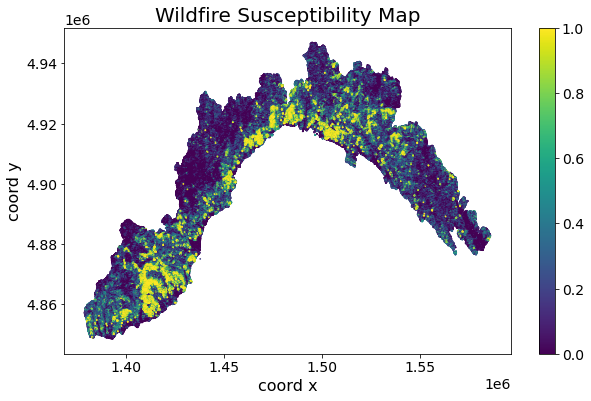